### **Prepared by: Dr. Hum Nath Bhandari, Department of Mathematics, RWU**

### **Course**: MATH 355/COMSC 415-Machine Learning 

###  **Case Study7** :  **Predicting S&P 500 Index Price Using Deep Learning Models** 

### Adapted by William Bailey 

###Date: 5/8/2023

In [ ]:
import pandas as pd 
from google.colab import drive
drive.mount('/content/drive')

data_path = "/content/drive/My Drive/Data_Capstone_Group2P/Data_model/"
output_dir_path = "/content/drive/My Drive/Data_Capstone_Group2P/Results/"

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

import pandas as pd  ##import necessary libraries
import numpy as np
import math
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme(style="whitegrid")
#plt.style.use('ggplot')


import tensorflow as tf
%load_ext tensorboard

import warnings
warnings.filterwarnings('ignore')

import os
import datetime as dt
import pandas_datareader.data as web

!pip install yfinance
import yfinance as yf

!pip install fredapi
from fredapi import Fred
fred = Fred(api_key='b9bebe3287b6308adffe3f8ab7e675ae')
#fred.search('10-year U.S tresury')

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Conv1D, MaxPooling2D, MaxPooling1D, Flatten
from tensorflow.keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import time
import math

Mounted at /content/drive
Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Creates a folder for each ticker

In [ ]:
#!pip install PyDrive

#import os
#for ticker in tickers:
  # Set the parent directory path
  #parent_dir = "/content/drive/My Drive/Data_Capstone_Group2P/Results/"

  # Name of the new directory to be created
  #new_folder = ticker

  # Path of the new directory
  #path = os.path.join(parent_dir, new_folder)

  # Create the new directory
  #try:
      #os.makedirs(path)
      #print("Directory '%s' created successfully." % new_folder)
  #except OSError as error:
      #print("Directory '%s' could not be created: %s" % (new_folder, error))

In [ ]:
tickers = ['MSFT','AMZN','AAPL']


# Create GRU and LSTM models 

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return (np.mean(np.abs((y_true - y_pred)/(y_true))*100)) #some issues with zero denominator

def calculate_scores(y_true, y_pred):
  rmse = math.sqrt(mean_squared_error(y_true, y_pred))
  #R2_score = r2_score(y_true, y_pred)
  R = np.corrcoef(y_true, y_pred)
  #mae = mean_absolute_error(y_true, y_pred)
  mape = mean_absolute_percentage_error(y_true, y_pred)
  #dic = {'rmse':rmse, 'R2_score': R2_score, 'R':R[0,1], 'mae': mae, 'mape': mape}
  dic = {'rmse':rmse, 'R': R[0,1], 'mape': mape}
  return (dic)



def DatasetCreation(dataset, time_step = 1):  ##defining a function that gives a dataset and a time step, which then returns the input and output data
   DataX, DataY = [], []
   for i in range(len(dataset)- time_step -1):
         a = dataset[i:(i+ time_step), ]
         DataX.append(a)
         DataY.append(dataset[i + time_step, 1]) #ydata consists close price
   return np.array(DataX), np.array(DataY)


def data_split(data, split = 0.2):
  #======= creating training and test data===#
  l1   = int(len(data) * (1- split))
  l2    = len(data) - l1
  data1  = data.iloc[0:l1,:]
  data2   = data.iloc[l1:len(data),:]
  return data1, data2

def min_max_transform(data, feature_range=(0, 1)):
   scaler = MinMaxScaler(feature_range) 
   return scaler.fit_transform(data)

def min_max_inverse_transform(data_scaled, min_original, max_original):
    return min_original +  data_scaled*(max_original - min_original)



def write_dic_to_file(dic_name, file_name):
  file = open(file_name, 'w')
  file.write(str(dic_name))
  file.close()

import ast
def read_dic_from_file(file_name):
  file = open(file_name, "r")
  contents = file.read()
  dictionary = ast.literal_eval(contents)
  file.close()
  return dictionary



def Build_LSTM_Model(layers, time_step, num_features, optimizer = 'Adam', learning_rate = 0.001, verbose = 1):
  
  model = Sequential()
    
  for i in range(len(layers)):
    if len(layers)==1:
      model.add(LSTM(np.int(layers[i]), input_shape = (time_step, num_features)))
    else:
      if i < len(layers)-1:
        if i == 0:
          model.add(LSTM(np.int(layers[i]), input_shape=(time_step, num_features), return_sequences= True))
          #model.add(Dropout(0.10))
        else:
          model.add(LSTM(np.int(layers[i]), return_sequences=True))
          #model.add(Dropout(0.10))
      else:
        model.add(LSTM(np.int(layers[i])))
        #model.add(Dropout(0.10))
        
          
  model.add(Dense(1, activation = 'linear'))
  
  if optimizer == 'Adam':
    opt = optimizers.Adam(learning_rate = learning_rate)
  elif optimizer == 'Adagrad': 
    opt = optimizers.Adagrad(learning_rate = learning_rate)
  elif optimizer == 'Nadam':
    opt = optimizers.Nadam(learning_rate = learning_rate)
  elif optimizer == 'Adadelta':
    opt = optimizers.Adadelta(learning_rate= learning_rate)
  elif optimizer == 'RMSprop':
    opt = optimizers.RMSprop(learning_rate= learning_rate)
  else:
    print("No optimizer found in the list(['Adam', 'Adagrad','Nadam', 'Adadelta', 'RMSprop'])! Please apply your optimizer manually...")

  model.compile(loss='mean_squared_error', optimizer= opt)
   
  if verbose == 1:
    print(model.summary())
  return model


def LSTM_Model(layers, hyper_parameters, data, time_step = 10, test_split = 0.2, epochs = 5,  num_replicates = 2):
    #====== data transformation==========#
    print("Progress: Performing data preparation steps.......\n")

    #======= creating training and test data===#


    train_data, test_data = data_split(data, test_split)

    num_features = train_data.shape[1]
  
    min_train, max_train  = train_data["close"].min(), train_data["close"].max()
    min_test, max_test   =  test_data["close"].min(), test_data["close"].max()

    train_data_scaled  =  min_max_transform(train_data)
    test_data_scaled   = min_max_transform(test_data)
  
 
    X_train, y_train  =   DatasetCreation(train_data_scaled, time_step)
    X_test, y_test    =   DatasetCreation(test_data_scaled, time_step)

    y_train_original  =  min_max_inverse_transform(y_train, min_train, max_train) #in original scale
    y_test_original  =  min_max_inverse_transform(y_test, min_test, max_test) #in original scale
  
  
    #============ arrays for collecting test scores ================#
    rmse_array = np.zeros(num_replicates)
    mape_array = np.zeros(num_replicates)
    R_array    = np.zeros(num_replicates)
    elapsed_time_array = np.zeros(num_replicates)

    models_history = []
    train_predictions = []
    test_predictions = []

    for i in range(num_replicates):

      print("Program is running for %d replicate ----->\n" %i)
     
      model = Build_LSTM_Model(layers, time_step, num_features, optimizer = hyper_parameters[0], learning_rate = hyper_parameters[1], verbose = 0)
      callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience= 5)
      # This callback will stop the training when there is no improvement in
      # the loss for three consecutive epochs
      start = time.time()
      history = model.fit(X_train, y_train, batch_size = hyper_parameters[2], epochs= epochs, callbacks=[callback], verbose = 1)
      end = time.time()
      elapsed_time = end - start
      
      models_history.append(history)


      #==============Making train and test prediction in original scales ==========
      train_pred   =  min_max_inverse_transform(model.predict(X_train).ravel(), min_train, max_train) #in original scale
      test_pred    =  min_max_inverse_transform(model.predict(X_test).ravel(), min_test, max_test)

      train_predictions.append(train_pred)
      test_predictions.append(test_pred)
      
      #============== Calculating performance scores==========
      #train_scores =  calculate_scores(min_max_inverse_transform(y_train, min_train, max_train),train_pred)
      scores =   calculate_scores(min_max_inverse_transform(y_test, min_test, max_test),test_pred)

      rmse_array[i] =  scores['rmse']
      mape_array[i] =  scores['mape']
      R_array[i] = scores['R']
      elapsed_time_array[i] = elapsed_time

    min_index = rmse_array.argmin()
    best_rmse = rmse_array[min_index]
    mape_with_best_rmse = mape_array[min_index]
    R_with_best_rmse =  R_array[min_index]
    elapsed_time_with_best_rmse = elapsed_time_array[min_index]

    train_predictions_with_best_rmse = train_predictions[min_index]
    test_predictions_with_best_rmse = test_predictions[min_index]

    loss_with_best_rmse = models_history[min_index].history['loss']

    #val_loss_with_best_rmse = models_history[min_index].history['val_loss']

   
    # Collecting important results========
    performance_metrics =  {
      
                        'scores': {'rmse': rmse_array, 
                                    'mape': mape_array, 
                                    'R': R_array,
                                    'elapsed_time': elapsed_time_array
                                    },
                          
                        'minimums': {'rmse': np.min(rmse_array),
                                      'mape': np.min(mape_array), 
                                      'R': np.min(R_array), 
                                      'elapsed_time': np.min(elapsed_time_array)
                                      },

                        'avg_scores':  {'rmse': np.mean(rmse_array), 
                                        'mape': np.mean(mape_array), 
                                        'R': np.mean(R_array), 
                                        'elapsed_time': np.mean(elapsed_time_array)
                                        }, 
                          
                          'stds':      { 'rmse': np.std(rmse_array),
                                          'mape': np.std(mape_array),
                                          'R': np.std(R_array), 
                                          'elapsed_time': np.std(elapsed_time_array)
                                        },
                          
                        'maximums': {'rmse': np.max(rmse_array), 
                                     'mape': np.max(mape_array),
                                     'R': np.max(R_array), 
                                     'elapsed_time': np.max(elapsed_time_array)
                                     }
                                      
                  }




    model_with_best_rmse = { 
                            
                            'replicate': min_index,
                            'rmse': best_rmse,
                            #'mae': mae_with_best_rmse,
                            'mape': mape_with_best_rmse,
                            #'R2': R2_with_best_rmse,
                            'R':  R_with_best_rmse,
                            'elapsed_time': elapsed_time_with_best_rmse,
                            'train_predictions':train_predictions_with_best_rmse,
                            'test_predictions': test_predictions_with_best_rmse,
                            'y_train':y_train_original,
                            'y_test': y_test_original,
                            'loss':loss_with_best_rmse,
                             #'val_loss': val_loss_with_best_rmse      
                            }

     #======= Collecting hyperparameters=============#                           
    hyper_parameters = {'layers': layers,
                        'model_specific_hyper_parameters': hyper_parameters,#additional best_hyper_parmeters for each models
                       'epochs': epochs,
                       'time_step':time_step,
                       'num_replicates': num_replicates,
                       'test_split':test_split
                        }


     #======= Collecting all the outputs together =============#  
    output_dictionary = {'hyper_parameters': hyper_parameters,
                        'performance_metrics': performance_metrics,
                         'best_model': model_with_best_rmse,
                       }            
    
  
    #Save all scores in a file for statistical study
    pd.DataFrame(performance_metrics['scores']['rmse']).to_csv(output_dir_path+'lstm-'+ str(layers)+'-rmse.csv')
    pd.DataFrame(performance_metrics['scores']['mape']).to_csv(output_dir_path+'lstm-'+ str(layers)+'-mape.csv')
    pd.DataFrame(performance_metrics['scores']['R']).to_csv(output_dir_path+'lstm-'+ str(layers)+'-R.csv')



    #Save data sets

    pd.DataFrame(y_train_original).to_csv(output_dir_path+'y_train.csv')
    pd.DataFrame(y_test_original).to_csv(output_dir_path+'y_test.csv')

    #Save best model results

    pd.DataFrame(model_with_best_rmse['train_predictions']).to_csv(output_dir_path+'best-lstm-'+ str(layers)+'-train_predictions.csv')
    pd.DataFrame(model_with_best_rmse['test_predictions']).to_csv(output_dir_path +'best-lstm-'+ str(layers)+'-test_predictions.csv')
    pd.DataFrame(model_with_best_rmse['loss']).to_csv(output_dir_path+ 'best-lstm-'+ str(layers)+'-loss.csv')

    #model_with_best_rmse['val_loss'].to_csv(output_dir_path+'best-lstm-model-val-loss.csv')
    
  
    #writing output dictionary in the file
    file_name = output_dir_path +'lstm-'+ str(layers)+'-full-results.txt'
    write_dic_to_file(output_dictionary, file_name)
  
    print("Progress: All works are done successfully, congratulations!!\n")
    return output_dictionary


def Build_GRU_Model(layers, time_step, num_features, optimizer = 'Adam', learning_rate = 0.001, verbose = 1):
  
  model = Sequential()
    
  for i in range(len(layers)):
    if len(layers)==1:
      model.add(GRU(np.int(layers[i]), input_shape = (time_step, num_features)))
    else:
      if i < len(layers)-1:
        if i == 0:
          model.add(GRU(np.int(layers[i]), input_shape=(time_step, num_features), return_sequences= True))
          #model.add(Dropout(0.10))
        else:
          model.add(GRU(np.int(layers[i]), return_sequences=True))
          #model.add(Dropout(0.10))
      else:
        model.add(GRU(np.int(layers[i])))
        #model.add(Dropout(0.10))  
  model.add(Dense(1, activation = 'linear'))
  
  if optimizer == 'Adam':
    opt = optimizers.Adam(learning_rate = learning_rate)
  elif optimizer == 'Adagrad': 
    opt = optimizers.Adagrad(learning_rate = learning_rate)
  elif optimizer == 'Nadam':
    opt = optimizers.Nadam(learning_rate = learning_rate)
  elif optimizer == 'Adadelta':
    opt = optimizers.Adadelta(learning_rate= learning_rate)
  elif optimizer == 'RMSprop':
    opt = optimizers.RMSprop(learning_rate= learning_rate)
  else:
    print("No optimizer found in the list(['Adam', 'Adagrad','Nadam', 'Adadelta', 'RMSprop'])! Please apply your optimizer manually...")

  model.compile(loss='mean_squared_error', optimizer= opt)
   
  if verbose == 1:
    print(model.summary())
  return model

def GRU_Model(layers, hyper_parameters, data, time_step = 10, test_split = 0.2, epochs = 5,  num_replicates = 2):
    #====== data transformation==========#
    print("Progress: Performing data preparation steps.......\n")

    #======= creating training and test data===#

    train_data, test_data = data_split(data, test_split)

    num_features = train_data.shape[1]
  
    min_train, max_train  = train_data["close"].min(), train_data["close"].max()
    min_test, max_test   =  test_data["close"].min(), test_data["close"].max()

    train_data_scaled  =  min_max_transform(train_data)
    test_data_scaled   = min_max_transform(test_data)
  
 
    X_train, y_train  =   DatasetCreation(train_data_scaled, time_step)
    X_test, y_test    =   DatasetCreation(test_data_scaled, time_step)

    y_train_original  =  min_max_inverse_transform(y_train, min_train, max_train) #in original scale
    y_test_original  =  min_max_inverse_transform(y_test, min_test, max_test) #in original scale
  
  
    #============ arrays for collecting test scores ================#
    rmse_array = np.zeros(num_replicates)
    mape_array = np.zeros(num_replicates)
    R_array    = np.zeros(num_replicates)
    elapsed_time_array = np.zeros(num_replicates)

    models_history = []
    train_predictions = []
    test_predictions = []

    for i in range(num_replicates):

      print("Program is running for %d replicate ----->\n" %i)
     
      model = Build_GRU_Model(layers, time_step, num_features, optimizer = hyper_parameters[0], learning_rate = hyper_parameters[1], verbose = 0)
      callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience= 5)
      # This callback will stop the training when there is no improvement in
      # the loss for three consecutive epochs
      start = time.time()
      history = model.fit(X_train, y_train, batch_size = hyper_parameters[2], epochs= epochs, callbacks=[callback], verbose = 1)
      end = time.time()
      elapsed_time = end - start
      
      models_history.append(history)


      #==============Making train and test prediction in original scales ==========
      train_pred   =  min_max_inverse_transform(model.predict(X_train).ravel(), min_train, max_train) #in original scale
      test_pred    =  min_max_inverse_transform(model.predict(X_test).ravel(), min_test, max_test)

      train_predictions.append(train_pred)
      test_predictions.append(test_pred)
      
      #============== Calculating performance scores==========
      #train_scores =  calculate_scores(min_max_inverse_transform(y_train, min_train, max_train),train_pred)
      scores =   calculate_scores(min_max_inverse_transform(y_test, min_test, max_test),test_pred)

      rmse_array[i] =  scores['rmse']
      mape_array[i] =  scores['mape']
      R_array[i] = scores['R']
      elapsed_time_array[i] = elapsed_time

    min_index = rmse_array.argmin()
    best_rmse = rmse_array[min_index]
    mape_with_best_rmse = mape_array[min_index]
    R_with_best_rmse =  R_array[min_index]
    elapsed_time_with_best_rmse = elapsed_time_array[min_index]

    train_predictions_with_best_rmse = train_predictions[min_index]
    test_predictions_with_best_rmse = test_predictions[min_index]

    loss_with_best_rmse = models_history[min_index].history['loss']

    #val_loss_with_best_rmse = models_history[min_index].history['val_loss']

    # Collecting important results========
    performance_metrics =  {
      
                        'scores': {'rmse': rmse_array, 
                                    'mape': mape_array, 
                                    'R': R_array,
                                    'elapsed_time': elapsed_time_array
                                    },
                          
                        'minimums': {'rmse': np.min(rmse_array),
                                      'mape': np.min(mape_array), 
                                      'R': np.min(R_array), 
                                      'elapsed_time': np.min(elapsed_time_array)
                                      },

                        'avg_scores':  {'rmse': np.mean(rmse_array), 
                                        'mape': np.mean(mape_array), 
                                        'R': np.mean(R_array), 
                                        'elapsed_time': np.mean(elapsed_time_array)
                                        }, 
                          
                          'stds':      { 'rmse': np.std(rmse_array),
                                          'mape': np.std(mape_array),
                                          'R': np.std(R_array), 
                                          'elapsed_time': np.std(elapsed_time_array)
                                        },
                          
                        'maximums': {'rmse': np.max(rmse_array), 
                                     'mape': np.max(mape_array),
                                     'R': np.max(R_array), 
                                     'elapsed_time': np.max(elapsed_time_array)
                                     }
                                      
                  }




    model_with_best_rmse = { 
                            
                            'replicate': min_index,
                            'rmse': best_rmse,
                            #'mae': mae_with_best_rmse,
                            'mape': mape_with_best_rmse,
                            #'R2': R2_with_best_rmse,
                            'R':  R_with_best_rmse,
                            'elapsed_time': elapsed_time_with_best_rmse,
                            'train_predictions':train_predictions_with_best_rmse,
                            'test_predictions': test_predictions_with_best_rmse,
                            #'y_train':y_train_original,
                            #'y_test': y_test_original,
                            'loss':loss_with_best_rmse,
                             #'val_loss': val_loss_with_best_rmse      
                            }

     #======= Collecting hyperparameters=============#                           
    hyper_parameters = {'layers': layers,
                        'model_specific_hyper_parameters': hyper_parameters,#additional best_hyper_parmeters for each models
                       'epochs': epochs,
                       'time_step':time_step,
                       'num_replicates': num_replicates,
                       'test_split':test_split
                        }

                
    
    #datasets  =   {'data': data, 
     #             'X_train': X_train,
     #             'X_test': X_test,
      #            'y_train': y_train_original,
     #             'y_test': y_test_original
      #            }
     #======= Collecting all the outputs together =============#  
    output_dictionary = {'hyper_parameters': hyper_parameters,
                        'performance_metrics': performance_metrics,
                         'best_model': model_with_best_rmse,
                       }            
    
  
    #Save all scores in a file for statistical study
    pd.DataFrame(performance_metrics['scores']['rmse']).to_csv(output_dir_path+'gru-'+ str(layers)+'-rmse.csv')
    pd.DataFrame(performance_metrics['scores']['mape']).to_csv(output_dir_path+'gru-'+ str(layers)+'-mape.csv')
    pd.DataFrame(performance_metrics['scores']['R']).to_csv(output_dir_path+'gru-'+ str(layers)+'-R.csv')



    #Save data sets

    pd.DataFrame(y_train_original).to_csv(output_dir_path+'y_train.csv')
    pd.DataFrame(y_test_original).to_csv(output_dir_path+'y_test.csv')

    #Save best model results

    pd.DataFrame(model_with_best_rmse['train_predictions']).to_csv(output_dir_path+'best-gru-'+ str(layers)+'-train_predictions.csv')
    pd.DataFrame(model_with_best_rmse['test_predictions']).to_csv(output_dir_path +'best-gru-'+ str(layers)+'-test_predictions.csv')
    pd.DataFrame(model_with_best_rmse['loss']).to_csv(output_dir_path+ 'best-gru-'+ str(layers)+'-loss.csv')

    #model_with_best_rmse['val_loss'].to_csv(output_dir_path+'best-lstm-model-val-loss.csv')
    
    #writing all statistics 
    #write_dic_to_file(performance_metrics,  output_dir_path + 'gru-'+ str(layers)+'-performance_metrics.txt')
    
    #writing output dictionary in the file
    file_name = output_dir_path +'gru-'+ str(layers)+'-full-results.txt'
    write_dic_to_file(output_dictionary, file_name)
    print("Progress: All works are done successfully, congratulations!!\n")
    return output_dictionary

In [ ]:
optimizers_names = ['Adam', 'Adagrad', 'Nadam']
time_step = 10
num_features = 10
learning_rate = 0.001
verbose = 1
layers = [50]

Build_LSTM_Model(layers, time_step, num_features, optimizer =  optimizers_names[0], learning_rate= learning_rate, verbose = verbose)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                12200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 12,251
Trainable params: 12,251
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
optimizers_names = ['Adam', 'Adagrad', 'Nadam']
time_step = 10
num_features = 10
learning_rate = 0.001
verbose = 1
layers = [50]

Build_GRU_Model(layers, time_step, num_features, optimizer =  optimizers_names[0], learning_rate= learning_rate, verbose = verbose)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50)                9300      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 9,351
Trainable params: 9,351
Non-trainable params: 0
_________________________________________________________________
None


###Intialize the output paths

In [ ]:
for ticker in tickers:
  ticker = ticker+"/"
  output_dir_path = "/content/drive/My Drive/Data_Capstone_Group2P/Results/"+ticker
  print(output_dir_path)

/content/drive/My Drive/Data_Capstone_Group2P/Results/MSFT/


###Run GRU and LSTM models for tickers

In [ ]:
for ticker in tickers:
  data = pd.read_csv(data_path+ticker+'.csv')
  ticker = ticker+"/"
  output_dir_path = "/content/drive/My Drive/Data_Capstone_Group2P/Results/"+ticker
  data.rename(columns = {'Unnamed: 0': 'Date'}, inplace = True)
  data = data.set_index('Date')
  #data = data.iloc[27:]
  #Turn data from 2016-2021 to 2018-2018
  data = data.iloc[503:]
print(data)



                         close         sma      macd  macd_signal        rsi  \
Date                                                                           
(503, 2018-01-02)    85.949997   84.843000  0.756062     0.832735  59.496486   
(504, 2018-01-03)    86.349998   85.106500  0.769964     0.820181  61.742963   
(505, 2018-01-04)    87.110001   85.382500  0.832707     0.822686  65.642142   
(506, 2018-01-05)    88.190002   85.653000  0.958530     0.849855  70.278038   
(507, 2018-01-08)    88.279999   85.942500  1.053365     0.890557  70.633623   
...                        ...         ...       ...          ...        ...   
(1506, 2021-12-27)  342.450012  331.507501  1.097262     0.778483  59.270353   
(1507, 2021-12-28)  341.250000  331.738501  1.726858     0.968158  58.131276   
(1508, 2021-12-29)  341.950012  332.306502  2.256293     1.225785  58.630733   
(1509, 2021-12-30)  339.320007  332.768503  2.435579     1.467743  55.931143   
(1510, 2021-12-31)  336.320007  333.1100

## **LSTM**

- layers = [10,20,30,50,100]

- hyper_parameters = ['Adam', 0.0075, 8]# optimzer, learning rate, batch_size

- epochs = 15

- num_replicates = 30

In [ ]:
for ticker in tickers:
  layers = [10]

  hyper_parameters = ['Adam', 0.0075, 8]# [optimzer, learning rate, batch_size]

  epochs = 15

  num_replicates = 30

  lstm10_output = LSTM_Model(layers, hyper_parameters, data, time_step = 10, test_split = 0.2, epochs = epochs,  num_replicates = num_replicates) 
  lstm10_output

  layers = [20]

  hyper_parameters = ['Adam', 0.0075, 8]# [optimzer, learning rate, batch_size]

  epochs = 15

  num_replicates = 30

  lstm20_output = LSTM_Model(layers, hyper_parameters, data, time_step = 10, test_split = 0.2, epochs = epochs,  num_replicates = num_replicates) 
  lstm20_output


  layers = [30]

  hyper_parameters = ['Adam', 0.0075, 8]# [optimzer, learning rate, batch_size]

  epochs = 15

  num_replicates = 30

  lstm30_output = LSTM_Model(layers, hyper_parameters, data, time_step = 10, test_split = 0.2, epochs = epochs,  num_replicates = num_replicates) 
  lstm30_output

  layers = [50]

  hyper_parameters = ['Adam', 0.0075, 8]# [optimzer, learning rate, batch_size]

  epochs = 15

  num_replicates = 30

  lstm50_output = LSTM_Model(layers, hyper_parameters, data, time_step = 10, test_split = 0.2, epochs = epochs,  num_replicates = num_replicates) 
  lstm50_output


  layers = [100]

  hyper_parameters = ['Adam', 0.0075, 8]# [optimzer, learning rate, batch_size]

  epochs = 15

  num_replicates = 30

  lstm100_output = LSTM_Model(layers, hyper_parameters, data, time_step = 10, test_split = 0.2, epochs = epochs,  num_replicates = num_replicates) 
  lstm100_output

Progress: Performing data preparation steps.......

Program is running for 0 replicate ----->

Epoch 1/15
100/100 [==============================] - 3s 5ms/step - loss: 0.0235
Epoch 2/15
100/100 [==============================] - 1s 6ms/step - loss: 5.8555e-04
Epoch 3/15
100/100 [==============================] - 1s 6ms/step - loss: 3.9623e-04
Epoch 4/15
100/100 [==============================] - 0s 5ms/step - loss: 2.0956e-04
Epoch 5/15
100/100 [==============================] - 1s 6ms/step - loss: 1.6531e-04
Epoch 6/15
100/100 [==============================] - 1s 6ms/step - loss: 1.5370e-04
Epoch 7/15
100/100 [==============================] - 1s 6ms/step - loss: 9.6920e-05
Epoch 8/15
100/100 [==============================] - 1s 7ms/step - loss: 9.8269e-05
Epoch 9/15
100/100 [==============================] - 1s 7ms/step - loss: 1.1971e-04
Epoch 10/15
100/100 [==============================] - 1s 6ms/step - loss: 9.9803e-05
Epoch 11/15
100/100 [==============================] - 1s 

## **GRU**

- layers = [10,20,30,50,100]

- hyper_parameters = ['Adam', 0.0075, 8]# optimzer, learning rate, batch_size

- epochs = 15

- num_replicates = 30

In [ ]:
for ticker in tickers:
  layers = [10]
  hyper_parameters = ['Adam', 0.0075, 8]# [optimzer, learning rate, batch_size]
  epochs = 15
  num_replicates = 30

  gru_output10 = GRU_Model(layers, hyper_parameters, data, time_step = 10, test_split = 0.2, epochs =epochs,  num_replicates = num_replicates) 
  gru_output10 


  layers = [20]
  hyper_parameters = ['Adam', 0.0075, 8]# [optimzer, learning rate, batch_size]
  epochs = 15
  num_replicates = 30

  gru_output20 = GRU_Model(layers, hyper_parameters, data, time_step = 10, test_split = 0.2, epochs =epochs,  num_replicates = num_replicates) 
  gru_output20 


  layers = [30]
  hyper_parameters = ['Adam', 0.0075, 8]# [optimzer, learning rate, batch_size]
  epochs = 15
  num_replicates = 30

  gru_output30 = GRU_Model(layers, hyper_parameters, data, time_step = 10, test_split = 0.2, epochs =epochs,  num_replicates = num_replicates) 
  gru_output30 



  layers = [50]
  hyper_parameters = ['Adam', 0.0075, 8]# [optimzer, learning rate, batch_size]
  epochs = 15
  num_replicates = 30

  gru_output50 = GRU_Model(layers, hyper_parameters, data, time_step = 10, test_split = 0.2, epochs =epochs,  num_replicates = num_replicates) 
  gru_output50 


  layers = [100]
  hyper_parameters = ['Adam', 0.0075, 8]# [optimzer, learning rate, batch_size]
  epochs = 15
  num_replicates = 30

  gru_output100 = GRU_Model(layers, hyper_parameters, data, time_step = 10, test_split = 0.2, epochs =epochs,  num_replicates = num_replicates) 
  gru_output100 

Progress: Performing data preparation steps.......

Program is running for 0 replicate ----->

Epoch 1/15
100/100 [==============================] - 6s 16ms/step - loss: 0.0442
Epoch 2/15
100/100 [==============================] - 1s 12ms/step - loss: 4.9625e-04
Epoch 3/15
100/100 [==============================] - 1s 11ms/step - loss: 2.5475e-04
Epoch 4/15
100/100 [==============================] - 1s 13ms/step - loss: 1.6341e-04
Epoch 5/15
100/100 [==============================] - 1s 11ms/step - loss: 1.2160e-04
Epoch 6/15
100/100 [==============================] - 1s 12ms/step - loss: 1.0460e-04
Epoch 7/15
100/100 [==============================] - 1s 12ms/step - loss: 8.6591e-05
Epoch 8/15
100/100 [==============================] - 1s 9ms/step - loss: 6.6207e-05
Epoch 9/15
100/100 [==============================] - 1s 11ms/step - loss: 7.6703e-05
Epoch 10/15
100/100 [==============================] - 1s 11ms/step - loss: 5.9605e-05
Epoch 11/15
100/100 [============================

###Loss Plots###

    10N-LSTM  20N-LSTM  30N-LSTM  50N-LSTM  100N-LSTM
0   0.007322  0.016330  0.008794  0.007086   0.018185
1   0.000180  0.000282  0.000269  0.000165   0.000153
2   0.000103  0.000156  0.000141  0.000086   0.000075
3   0.000076  0.000107  0.000085  0.000047   0.000092
4   0.000083  0.000115  0.000061  0.000034   0.000099
5   0.000061  0.000082  0.000046  0.000061   0.000081
6   0.000056  0.000117  0.000042  0.000102   0.000059
7   0.000059  0.000062  0.000036  0.000044   0.000057
8   0.000033  0.000067  0.000035  0.000051   0.000055
9   0.000053  0.000075  0.000053  0.000037   0.000037
10  0.000045  0.000050  0.000039       NaN   0.000040
11  0.000052  0.000066  0.000027       NaN   0.000056
12  0.000034  0.000049  0.000042       NaN   0.000041
13  0.000036  0.000030  0.000110       NaN   0.000029
14       NaN  0.000025  0.000059       NaN   0.000224
     10N-GRU   20N-GRU   30N-GRU   50N-GRU  100N-GRU
0   0.033572  0.004148  0.013924  0.010854  0.020483
1   0.000887  0.000061  0.0002

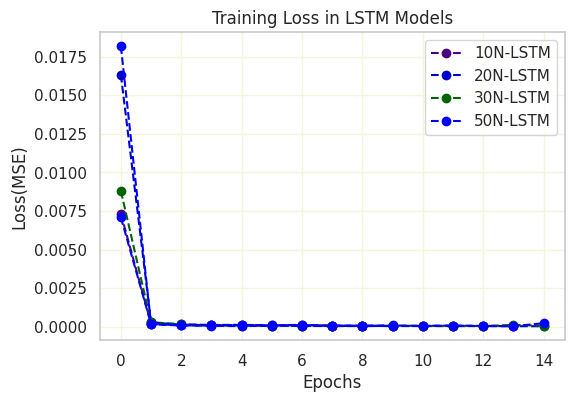

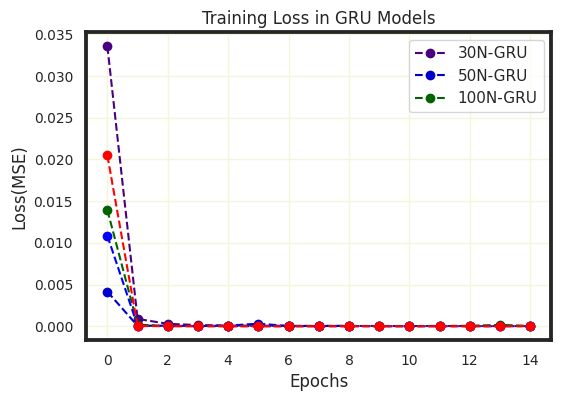

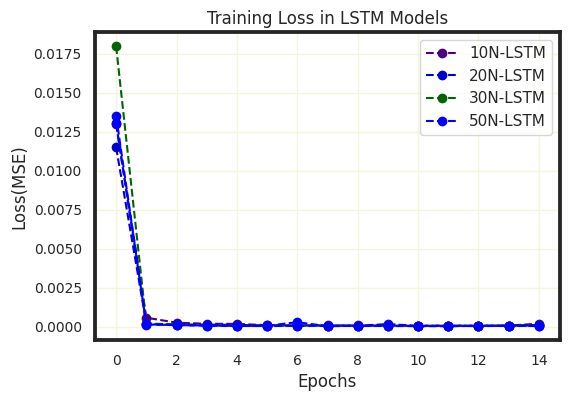

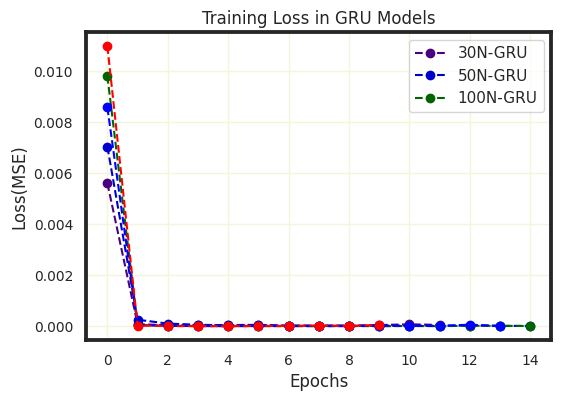

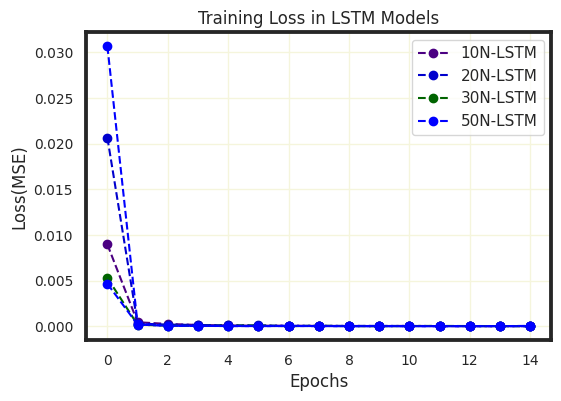

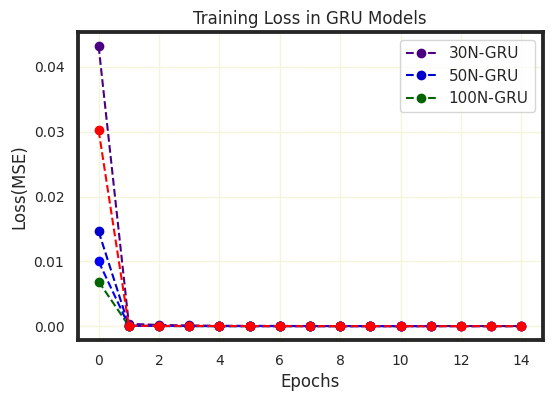

In [ ]:
for ticker in tickers:  
  def read_df_from_file(name):
    return pd.read_csv(name)

  ticker = ticker+"/"
  output_dir_path = "/content/drive/My Drive/Data_Capstone_Group2P/Results/"+ticker
  lstm_10n_best_loss  = pd.read_csv(output_dir_path + "best-lstm-[10]-loss.csv")
  lstm_20n_best_loss  = pd.read_csv(output_dir_path + "best-lstm-[20]-loss.csv")
  lstm_30n_best_loss  = pd.read_csv(output_dir_path + "best-lstm-[30]-loss.csv")
  lstm_50n_best_loss  = pd.read_csv(output_dir_path + "best-lstm-[50]-loss.csv")
  lstm_100n_best_loss  = pd.read_csv(output_dir_path + "best-lstm-[100]-loss.csv")

  lstm_loss = pd.DataFrame( { 
      
          '10N-LSTM': lstm_10n_best_loss.iloc[:,1],
          '20N-LSTM': lstm_20n_best_loss.iloc[:,1],
          '30N-LSTM': lstm_30n_best_loss.iloc[:,1],
          '50N-LSTM': lstm_50n_best_loss.iloc[:,1],
          '100N-LSTM': lstm_100n_best_loss.iloc[:,1], 

      })


  print(lstm_loss)

  fig = plt.figure(figsize = (6,4))

  colors = ['indigo', 'mediumblue','darkgreen', 'blue', 'red']

  plt.plot(lstm_loss.index, lstm_loss['10N-LSTM'], '--o',  linewidth = 1.5, color = colors[0])
  plt.plot(lstm_loss.index, lstm_loss['20N-LSTM'], '--o',  linewidth = 1.5, color = colors[1])
  plt.plot(lstm_loss.index, lstm_loss['30N-LSTM'], '--o',  linewidth = 1.5, color = colors[2])
  plt.plot(lstm_loss.index, lstm_loss['50N-LSTM'], '--o',  linewidth = 1.5, color = colors[3])
  plt.plot(lstm_loss.index, lstm_loss['100N-LSTM'], '--o',  linewidth = 1.5, color = colors[3])

  plt.xlabel("Epochs")
  plt.ylabel("Loss(MSE)")
  plt.title("Training Loss in LSTM Models")
  plt.legend(['10N-LSTM', '20N-LSTM',	'30N-LSTM',	'50N-LSTM'],  loc = 'upper right')
  #plt.rcParams['axes.facecolor']='w'
  plt.grid(color='#F5F5DC')

  plt.rcParams["axes.edgecolor"] = "0.15"
  plt.rcParams["axes.linewidth"]  = 2.75
  plt.rc('xtick',labelsize=10)
  plt.rc('ytick',labelsize=10) 

    
  fig.savefig(output_dir_path +"lstm_loss_plot.png",dpi=600)


  gru_10n_best_loss  = pd.read_csv(output_dir_path + "best-gru-[10]-loss.csv")
  gru_20n_best_loss  = pd.read_csv(output_dir_path + "best-gru-[20]-loss.csv")
  gru_30n_best_loss  = pd.read_csv(output_dir_path + "best-gru-[30]-loss.csv")
  gru_50n_best_loss  = pd.read_csv(output_dir_path + "best-gru-[50]-loss.csv")
  gru_100n_best_loss  = pd.read_csv(output_dir_path + "best-gru-[100]-loss.csv")

  gru_loss = pd.DataFrame( { 
      
          '10N-GRU': gru_10n_best_loss.iloc[:,1],
          '20N-GRU': gru_20n_best_loss.iloc[:,1],
          '30N-GRU': gru_30n_best_loss.iloc[:,1],
          '50N-GRU': gru_50n_best_loss.iloc[:,1],
          '100N-GRU': gru_100n_best_loss.iloc[:,1], 
      })


  print(gru_loss)

  fig = plt.figure(figsize = (6,4))

  colors = ['indigo', 'mediumblue','darkgreen', 'blue', 'red']

  plt.plot(gru_loss.index, gru_loss['10N-GRU'], '--o',  linewidth = 1.5, color = colors[0])
  plt.plot(gru_loss.index, gru_loss['20N-GRU'], '--o',  linewidth = 1.5, color = colors[1])
  plt.plot(gru_loss.index, gru_loss['30N-GRU'], '--o',  linewidth = 1.5, color = colors[2])
  plt.plot(gru_loss.index, gru_loss['50N-GRU'], '--o',  linewidth = 1.5, color = colors[3])
  plt.plot(gru_loss.index, gru_loss['100N-GRU'], '--o',  linewidth = 1.5, color = colors[4])

  plt.xlabel("Epochs")
  plt.ylabel("Loss(MSE)")
  plt.title("Training Loss in GRU Models")
  plt.legend(['30N-GRU',	'50N-GRU',	'100N-GRU'],  loc = 'upper right')
  #plt.rcParams['axes.facecolor']='w'
  plt.grid(color='#F5F5DC')

  plt.rcParams["axes.edgecolor"] = "0.15"
  plt.rcParams["axes.linewidth"]  = 2.75
  plt.rc('xtick',labelsize=10)
  plt.rc('ytick',labelsize=10) 
  fig.savefig(output_dir_path +"gru_loss_plot.png",dpi=600)

#Apple Loss Plots

    10N-LSTM  20N-LSTM  30N-LSTM  50N-LSTM  100N-LSTM
0   0.008970  0.020658  0.005303  0.004667   0.030668
1   0.000456  0.000307  0.000188  0.000199   0.000296
2   0.000271  0.000200  0.000082  0.000064   0.000065
3   0.000158  0.000157  0.000049  0.000065   0.000053
4   0.000106  0.000119  0.000085  0.000034   0.000045
5   0.000077  0.000107  0.000091  0.000030   0.000035
6   0.000080  0.000073  0.000026  0.000045   0.000040
7   0.000055  0.000066  0.000072  0.000036   0.000033
8   0.000051  0.000058  0.000027  0.000022   0.000023
9   0.000039  0.000059  0.000018  0.000026   0.000033
10  0.000058  0.000047  0.000038  0.000017   0.000023
11  0.000036  0.000040  0.000055  0.000030   0.000019
12  0.000030  0.000047  0.000031  0.000022   0.000020
13  0.000026  0.000032  0.000037  0.000026   0.000035
14  0.000034  0.000025  0.000028  0.000061   0.000019
     10N-GRU   20N-GRU   30N-GRU   50N-GRU  100N-GRU
0   0.043157  0.014610  0.006888  0.009987  0.030182
1   0.000377  0.000089  0.0000

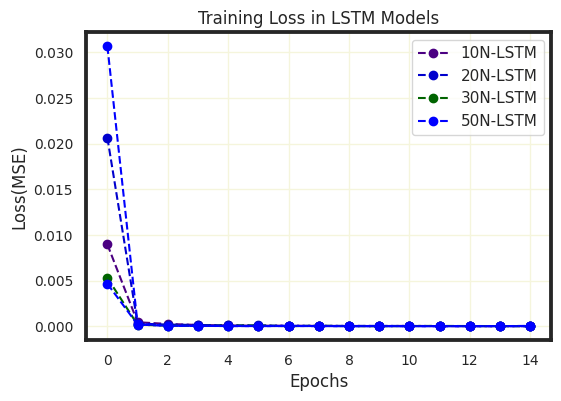

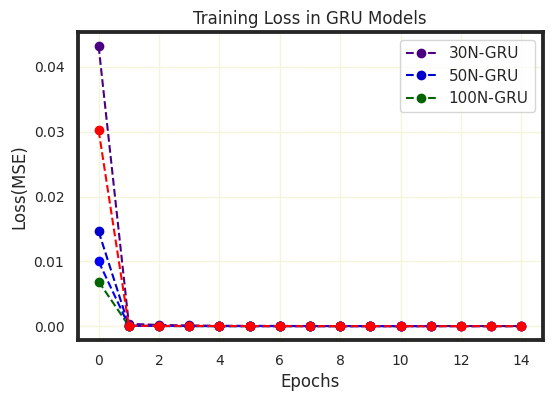

In [ ]:
def read_df_from_file(name):
    return pd.read_csv(name)

ticker = "AAPL/"
output_dir_path = "/content/drive/My Drive/Data_Capstone_Group2P/Results/"+ticker
lstm_10n_best_loss  = pd.read_csv(output_dir_path + "best-lstm-[10]-loss.csv")
lstm_20n_best_loss  = pd.read_csv(output_dir_path + "best-lstm-[20]-loss.csv")
lstm_30n_best_loss  = pd.read_csv(output_dir_path + "best-lstm-[30]-loss.csv")
lstm_50n_best_loss  = pd.read_csv(output_dir_path + "best-lstm-[50]-loss.csv")
lstm_100n_best_loss  = pd.read_csv(output_dir_path + "best-lstm-[100]-loss.csv")

lstm_loss = pd.DataFrame( { 
    
        '10N-LSTM': lstm_10n_best_loss.iloc[:,1],
        '20N-LSTM': lstm_20n_best_loss.iloc[:,1],
        '30N-LSTM': lstm_30n_best_loss.iloc[:,1],
        '50N-LSTM': lstm_50n_best_loss.iloc[:,1],
        '100N-LSTM': lstm_100n_best_loss.iloc[:,1], 

    })


print(lstm_loss)

fig = plt.figure(figsize = (6,4))

colors = ['indigo', 'mediumblue','darkgreen', 'blue', 'red']

plt.plot(lstm_loss.index, lstm_loss['10N-LSTM'], '--o',  linewidth = 1.5, color = colors[0])
plt.plot(lstm_loss.index, lstm_loss['20N-LSTM'], '--o',  linewidth = 1.5, color = colors[1])
plt.plot(lstm_loss.index, lstm_loss['30N-LSTM'], '--o',  linewidth = 1.5, color = colors[2])
plt.plot(lstm_loss.index, lstm_loss['50N-LSTM'], '--o',  linewidth = 1.5, color = colors[3])
plt.plot(lstm_loss.index, lstm_loss['100N-LSTM'], '--o',  linewidth = 1.5, color = colors[3])

plt.xlabel("Epochs")
plt.ylabel("Loss(MSE)")
plt.title("Training Loss in LSTM Models")
plt.legend(['10N-LSTM', '20N-LSTM',	'30N-LSTM',	'50N-LSTM'],  loc = 'upper right')
#plt.rcParams['axes.facecolor']='w'
plt.grid(color='#F5F5DC')

plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 2.75
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10) 

  
fig.savefig(output_dir_path +"lstm_loss_plot.png",dpi=600)


gru_10n_best_loss  = pd.read_csv(output_dir_path + "best-gru-[10]-loss.csv")
gru_20n_best_loss  = pd.read_csv(output_dir_path + "best-gru-[20]-loss.csv")
gru_30n_best_loss  = pd.read_csv(output_dir_path + "best-gru-[30]-loss.csv")
gru_50n_best_loss  = pd.read_csv(output_dir_path + "best-gru-[50]-loss.csv")
gru_100n_best_loss  = pd.read_csv(output_dir_path + "best-gru-[100]-loss.csv")

gru_loss = pd.DataFrame( { 
    
        '10N-GRU': gru_10n_best_loss.iloc[:,1],
        '20N-GRU': gru_20n_best_loss.iloc[:,1],
        '30N-GRU': gru_30n_best_loss.iloc[:,1],
        '50N-GRU': gru_50n_best_loss.iloc[:,1],
        '100N-GRU': gru_100n_best_loss.iloc[:,1], 
    })


print(gru_loss)

fig = plt.figure(figsize = (6,4))

colors = ['indigo', 'mediumblue','darkgreen', 'blue', 'red']

plt.plot(gru_loss.index, gru_loss['10N-GRU'], '--o',  linewidth = 1.5, color = colors[0])
plt.plot(gru_loss.index, gru_loss['20N-GRU'], '--o',  linewidth = 1.5, color = colors[1])
plt.plot(gru_loss.index, gru_loss['30N-GRU'], '--o',  linewidth = 1.5, color = colors[2])
plt.plot(gru_loss.index, gru_loss['50N-GRU'], '--o',  linewidth = 1.5, color = colors[3])
plt.plot(gru_loss.index, gru_loss['100N-GRU'], '--o',  linewidth = 1.5, color = colors[4])

plt.xlabel("Epochs")
plt.ylabel("Loss(MSE)")
plt.title("Training Loss in GRU Models")
plt.legend(['30N-GRU',	'50N-GRU',	'100N-GRU'],  loc = 'upper right')
#plt.rcParams['axes.facecolor']='w'
plt.grid(color='#F5F5DC')

plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 2.75
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10) 
fig.savefig(output_dir_path +"gru_loss_plot.png",dpi=600)

#Amazon Loss Plots

    10N-LSTM  20N-LSTM  30N-LSTM  50N-LSTM  100N-LSTM
0   0.012971  0.011487  0.017979  0.013040   0.013505
1   0.000572  0.000199  0.000191  0.000140   0.000129
2   0.000254  0.000139  0.000107  0.000104   0.000095
3   0.000182  0.000129  0.000063  0.000073   0.000069
4   0.000176  0.000113  0.000043  0.000043   0.000048
5   0.000092  0.000072  0.000047  0.000036   0.000054
6   0.000086  0.000074  0.000041  0.000055   0.000285
7   0.000073  0.000060  0.000045  0.000063   0.000027
8   0.000073  0.000060  0.000048  0.000047   0.000051
9   0.000064  0.000084  0.000040  0.000042   0.000165
10  0.000056  0.000045  0.000037  0.000035   0.000045
11  0.000057  0.000044  0.000042  0.000023   0.000065
12  0.000060  0.000061  0.000047  0.000050   0.000026
13  0.000066  0.000041  0.000068  0.000049   0.000066
14  0.000189  0.000067  0.000077  0.000037   0.000100
     10N-GRU   20N-GRU   30N-GRU   50N-GRU  100N-GRU
0   0.005606  0.007041  0.009805  0.008576  0.010970
1   0.000091  0.000265  0.0000

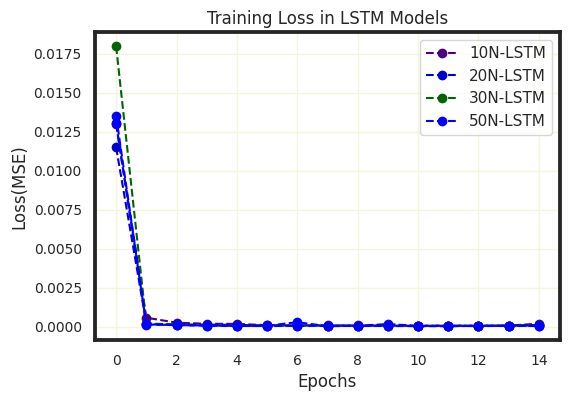

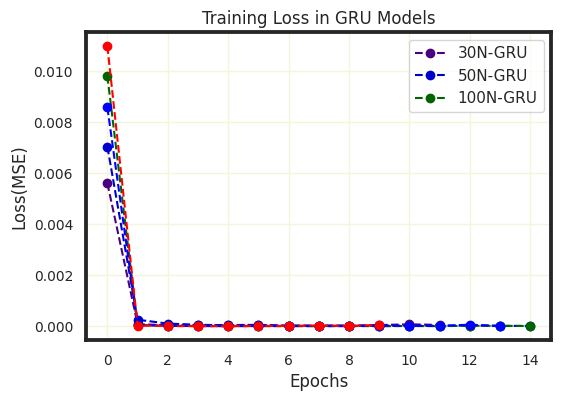

In [ ]:
def read_df_from_file(name):
    return pd.read_csv(name)

ticker = "AMZN/"
output_dir_path = "/content/drive/My Drive/Data_Capstone_Group2P/Results/"+ticker
lstm_10n_best_loss  = pd.read_csv(output_dir_path + "best-lstm-[10]-loss.csv")
lstm_20n_best_loss  = pd.read_csv(output_dir_path + "best-lstm-[20]-loss.csv")
lstm_30n_best_loss  = pd.read_csv(output_dir_path + "best-lstm-[30]-loss.csv")
lstm_50n_best_loss  = pd.read_csv(output_dir_path + "best-lstm-[50]-loss.csv")
lstm_100n_best_loss  = pd.read_csv(output_dir_path + "best-lstm-[100]-loss.csv")

lstm_loss = pd.DataFrame( { 
    
        '10N-LSTM': lstm_10n_best_loss.iloc[:,1],
        '20N-LSTM': lstm_20n_best_loss.iloc[:,1],
        '30N-LSTM': lstm_30n_best_loss.iloc[:,1],
        '50N-LSTM': lstm_50n_best_loss.iloc[:,1],
        '100N-LSTM': lstm_100n_best_loss.iloc[:,1], 

    })


print(lstm_loss)

fig = plt.figure(figsize = (6,4))

colors = ['indigo', 'mediumblue','darkgreen', 'blue', 'red']

plt.plot(lstm_loss.index, lstm_loss['10N-LSTM'], '--o',  linewidth = 1.5, color = colors[0])
plt.plot(lstm_loss.index, lstm_loss['20N-LSTM'], '--o',  linewidth = 1.5, color = colors[1])
plt.plot(lstm_loss.index, lstm_loss['30N-LSTM'], '--o',  linewidth = 1.5, color = colors[2])
plt.plot(lstm_loss.index, lstm_loss['50N-LSTM'], '--o',  linewidth = 1.5, color = colors[3])
plt.plot(lstm_loss.index, lstm_loss['100N-LSTM'], '--o',  linewidth = 1.5, color = colors[3])

plt.xlabel("Epochs")
plt.ylabel("Loss(MSE)")
plt.title("Training Loss in LSTM Models")
plt.legend(['10N-LSTM', '20N-LSTM',	'30N-LSTM',	'50N-LSTM'],  loc = 'upper right')
#plt.rcParams['axes.facecolor']='w'
plt.grid(color='#F5F5DC')

plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 2.75
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10) 

  
fig.savefig(output_dir_path +"lstm_loss_plot.png",dpi=600)


gru_10n_best_loss  = pd.read_csv(output_dir_path + "best-gru-[10]-loss.csv")
gru_20n_best_loss  = pd.read_csv(output_dir_path + "best-gru-[20]-loss.csv")
gru_30n_best_loss  = pd.read_csv(output_dir_path + "best-gru-[30]-loss.csv")
gru_50n_best_loss  = pd.read_csv(output_dir_path + "best-gru-[50]-loss.csv")
gru_100n_best_loss  = pd.read_csv(output_dir_path + "best-gru-[100]-loss.csv")

gru_loss = pd.DataFrame( { 
    
        '10N-GRU': gru_10n_best_loss.iloc[:,1],
        '20N-GRU': gru_20n_best_loss.iloc[:,1],
        '30N-GRU': gru_30n_best_loss.iloc[:,1],
        '50N-GRU': gru_50n_best_loss.iloc[:,1],
        '100N-GRU': gru_100n_best_loss.iloc[:,1], 
    })


print(gru_loss)

fig = plt.figure(figsize = (6,4))

colors = ['indigo', 'mediumblue','darkgreen', 'blue', 'red']

plt.plot(gru_loss.index, gru_loss['10N-GRU'], '--o',  linewidth = 1.5, color = colors[0])
plt.plot(gru_loss.index, gru_loss['20N-GRU'], '--o',  linewidth = 1.5, color = colors[1])
plt.plot(gru_loss.index, gru_loss['30N-GRU'], '--o',  linewidth = 1.5, color = colors[2])
plt.plot(gru_loss.index, gru_loss['50N-GRU'], '--o',  linewidth = 1.5, color = colors[3])
plt.plot(gru_loss.index, gru_loss['100N-GRU'], '--o',  linewidth = 1.5, color = colors[4])

plt.xlabel("Epochs")
plt.ylabel("Loss(MSE)")
plt.title("Training Loss in GRU Models")
plt.legend(['30N-GRU',	'50N-GRU',	'100N-GRU'],  loc = 'upper right')
#plt.rcParams['axes.facecolor']='w'
plt.grid(color='#F5F5DC')

plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 2.75
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10) 
fig.savefig(output_dir_path +"gru_loss_plot.png",dpi=600)

###RMSE, R, and MAPE scores###

In [ ]:
def plt_rmse(ticker):
  ticker = ticker+"/"
  output_dir_path = "/content/drive/My Drive/Data_Capstone_Group2P/Results/"+ticker
  lstm_10n_rmse   = pd.read_csv(output_dir_path + "lstm-[10]-rmse.csv")
  lstm_20n_rmse   = pd.read_csv(output_dir_path + "lstm-[20]-rmse.csv")
  lstm_30n_rmse   = pd.read_csv(output_dir_path + "lstm-[30]-rmse.csv")
  lstm_50n_rmse   = pd.read_csv(output_dir_path + "lstm-[50]-rmse.csv")
  lstm_100n_rmse  = pd.read_csv(output_dir_path + "lstm-[100]-rmse.csv")


  lstm_rmse = pd.DataFrame( { 
      
          '10N-LSTM': lstm_10n_rmse.iloc[:,1],
          '20N-LSTM': lstm_20n_rmse.iloc[:,1],
          '30N-LSTM': lstm_30n_rmse.iloc[:,1],
          '50N-LSTM': lstm_50n_rmse.iloc[:,1],
          '100N-LSTM': lstm_100n_rmse.iloc[:,1], 

      })

  gru_10n_rmse  = pd.read_csv(output_dir_path + "gru-[10]-rmse.csv")
  gru_20n_rmse  = pd.read_csv(output_dir_path + "gru-[20]-rmse.csv")
  gru_30n_rmse  = pd.read_csv(output_dir_path + "gru-[30]-rmse.csv")
  gru_50n_rmse  = pd.read_csv(output_dir_path + "gru-[50]-rmse.csv")
  gru_100n_rmse = pd.read_csv(output_dir_path + "gru-[100]-rmse.csv")

  gru_rmse = pd.DataFrame( { 
      
          '10N-GRU': gru_10n_rmse.iloc[:,1],
          '20N-GRU': gru_20n_rmse.iloc[:,1],
          '30N-GRU': gru_30n_rmse.iloc[:,1],
          '50N-GRU': gru_50n_rmse.iloc[:,1],
          '100N-GRU': gru_100n_rmse.iloc[:,1], 
      })



  lstm_10n_mape   = pd.read_csv(output_dir_path + "lstm-[10]-mape.csv")
  lstm_20n_mape   = pd.read_csv(output_dir_path + "lstm-[20]-mape.csv")
  lstm_30n_mape   = pd.read_csv(output_dir_path + "lstm-[30]-mape.csv")
  lstm_50n_mape  = pd.read_csv(output_dir_path + "lstm-[50]-mape.csv")
  lstm_100n_mape = pd.read_csv(output_dir_path + "lstm-[100]-mape.csv")


  lstm_mape = pd.DataFrame( { 
      
          '10N-LSTM': lstm_10n_mape.iloc[:,1],
          '20N-LSTM': lstm_20n_mape.iloc[:,1],
          '30N-LSTM': lstm_30n_mape.iloc[:,1],
          '50N-LSTM': lstm_50n_mape.iloc[:,1],
          '100N-LSTM': lstm_100n_mape.iloc[:,1], 
      })

  gru_10n_mape   = pd.read_csv(output_dir_path + "gru-[10]-mape.csv")
  gru_20n_mape   = pd.read_csv(output_dir_path + "gru-[20]-mape.csv")
  gru_30n_mape   = pd.read_csv(output_dir_path + "gru-[30]-mape.csv")
  gru_50n_mape   = pd.read_csv(output_dir_path + "gru-[50]-mape.csv")
  gru_100n_mape  = pd.read_csv(output_dir_path + "gru-[100]-mape.csv")


  gru_mape = pd.DataFrame( { 
      
          '10N-GRU': gru_10n_mape.iloc[:,1],
          '20N-GRU': gru_20n_mape.iloc[:,1],
          '30N-GRU': gru_30n_mape.iloc[:,1],
          '50N-GRU': gru_50n_mape.iloc[:,1],
          '100N-GRU': gru_100n_mape.iloc[:,1], 
      })


  lstm_10n_R = pd.read_csv(output_dir_path + "lstm-[10]-R.csv")
  lstm_20n_R = pd.read_csv(output_dir_path + "lstm-[20]-R.csv")
  lstm_30n_R = pd.read_csv(output_dir_path + "lstm-[30]-R.csv")
  lstm_50n_R = pd.read_csv(output_dir_path + "lstm-[50]-R.csv")
  lstm_100n_R = pd.read_csv(output_dir_path + "lstm-[100]-R.csv")


  lstm_R = pd.DataFrame( { 
      
          '10N-LSTM': lstm_10n_R.iloc[:,1],
          '20N-LSTM': lstm_20n_R.iloc[:,1],
          '30N-LSTM': lstm_30n_R.iloc[:,1],
          '50N-LSTM': lstm_50n_R.iloc[:,1],
          '100N-LSTM': lstm_100n_R.iloc[:,1], 

      })

  gru_10n_R  = pd.read_csv(output_dir_path + "gru-[10]-R.csv")
  gru_20n_R   = pd.read_csv(output_dir_path + "gru-[20]-R.csv")
  gru_30n_R   = pd.read_csv(output_dir_path + "gru-[30]-R.csv")
  gru_50n_R   = pd.read_csv(output_dir_path + "gru-[50]-R.csv")
  gru_100n_R  = pd.read_csv(output_dir_path + "gru-[100]-R.csv")


  gru_R = pd.DataFrame( { 
      
          '10N-GRU': gru_10n_R.iloc[:,1],
          '20N-GRU': gru_20n_R.iloc[:,1],
          '30N-GRU': gru_30n_R.iloc[:,1],
          '50N-GRU': gru_50n_R.iloc[:,1],
          '100N-GRU': gru_100n_R.iloc[:,1], 
      })

  #==========LSTM average score calculation==================
  lstm_average_score = pd.DataFrame( { 
              #"LSTM_Models": [ '10N-LSTM', '20N-LSTM','30N-LSTM','50N-LSTM', '100N-LSTM'],
              "Avg_RMSE": lstm_rmse.mean(),
              "Avg_MAPE": lstm_mape.mean(),
              "Avg_R": lstm_R.mean(),
      })

  print(lstm_average_score)


  #==========GRU average score calculation==================
  gru_average_score = pd.DataFrame( { 
              #"LSTM_Models": [ '50N-GRU', '100N-GRU'],
              "Avg_RMSE": gru_rmse.mean(),
              "Avg_MAPE": gru_mape.mean(),
              "Avg_R": gru_R.mean(),
      })


  print(gru_average_score)





  #========== Creating Visualization of average scores==================
  fig = plt.figure(figsize = (20, 4))

  models = ['10N', '20N','30N','50N', '100N']

  plt.subplot(131)
  plt.plot(models, lstm_average_score['Avg_RMSE'], '--o', linewidth = 2.5, color = 'indigo')
  plt.plot(models, gru_average_score['Avg_RMSE'], '-o', linewidth = 2.5, color = 'olive')
  plt.title("Avg.RMSE")
  plt.xlabel("Neurons")
  plt.ylabel("Avg. RMSE")
  plt.legend(['LSTM', 'GRU'],  loc = 'best')
    
  plt.rcParams["axes.edgecolor"] = "0.15"
  plt.rcParams["axes.linewidth"]  = 2.75
  plt.rc('xtick',labelsize=10)
  plt.rc('ytick',labelsize=10) 


    
  plt.subplot(132)

  plt.plot(models, lstm_average_score['Avg_MAPE'], '--o', linewidth = 2.5, color = 'indigo')
  plt.plot(models, gru_average_score['Avg_MAPE'], '-o', linewidth = 2.5, color = 'olive')
  plt.title("Avg. MAPE")
  plt.xlabel("Neurons")
  plt.ylabel("Avg. MAPE")
  plt.legend(['LSTM', 'GRU'],  loc = 'best')
    
  plt.rcParams["axes.edgecolor"] = "0.15"
  plt.rcParams["axes.linewidth"]  = 2.75
  plt.rc('xtick',labelsize=10)
  plt.rc('ytick',labelsize=10) 


  plt.subplot(133)

  plt.plot(models, lstm_average_score['Avg_R'], '--o', linewidth = 2.5, color = 'indigo')
  plt.plot(models, gru_average_score['Avg_R'], '-o', linewidth = 2.5, color = 'olive')
  plt.title("R")
  plt.xlabel("Neurons")
  plt.ylabel("Avg. R")
  plt.legend(['LSTM', 'GRU'],  loc = 'best')
    
  plt.rcParams["axes.edgecolor"] = "0.15"
  plt.rcParams["axes.linewidth"]  = 2.75
  plt.rc('xtick',labelsize=10)
  plt.rc('ytick',labelsize=10) 
    
  fig.savefig(output_dir_path+"avg_scores_plots.png",dpi=600)


#AAPL RMSE,MAPE, and R graphs

           Avg_RMSE  Avg_MAPE     Avg_R
10N-LSTM   1.057320  0.622957  0.998633
20N-LSTM   0.957734  0.572267  0.998898
30N-LSTM   0.793369  0.475201  0.999264
50N-LSTM   0.702988  0.418123  0.999395
100N-LSTM  0.619339  0.362015  0.999360
          Avg_RMSE  Avg_MAPE     Avg_R
10N-GRU   0.947016  0.591786  0.999318
20N-GRU   0.883772  0.530024  0.999093
30N-GRU   0.823693  0.514049  0.999527
50N-GRU   0.878092  0.542049  0.999463
100N-GRU  0.792971  0.491167  0.999548


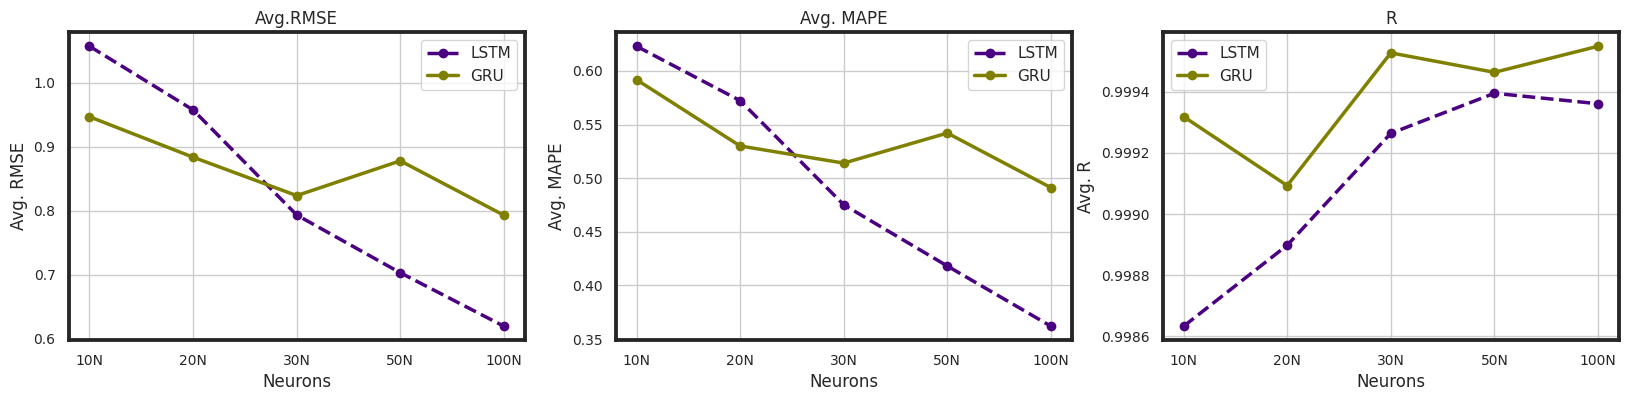

In [ ]:
plt_rmse('AAPL')

#AMZN RMSE,MAPE, and R graphs

           Avg_RMSE  Avg_MAPE     Avg_R
10N-LSTM   1.051493  0.501407  0.993013
20N-LSTM   0.956124  0.458262  0.994630
30N-LSTM   0.967799  0.467009  0.994728
50N-LSTM   0.967590  0.467116  0.995331
100N-LSTM  0.972196  0.472909  0.994942
          Avg_RMSE  Avg_MAPE     Avg_R
10N-GRU   1.050301  0.500766  0.992144
20N-GRU   1.274966  0.613462  0.987776
30N-GRU   1.085010  0.521347  0.991633
50N-GRU   1.118497  0.537357  0.991759
100N-GRU  1.103314  0.532848  0.992129


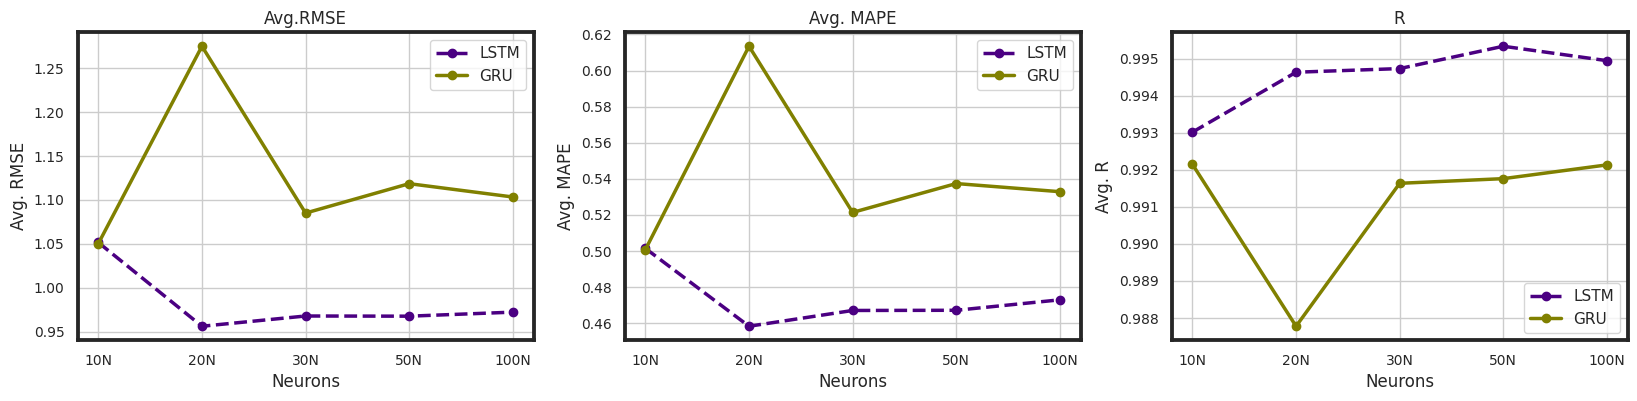

In [ ]:
plt_rmse('AMZN')

### Best Performing Model
Our selection criteria was primarily based on average RMSE. After tuning the model it was found that the 100 Neuron LSTM model consistently performed the best. This was achieved with a the following hyperparameters.

1.   Optimizer = Adam 
2.   Learning Rate = .0075
3.   Batch size = 8
4.   Time Step = 10

